In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[11] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [4]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


# proper vs strictly proper for SIR curve

In [5]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



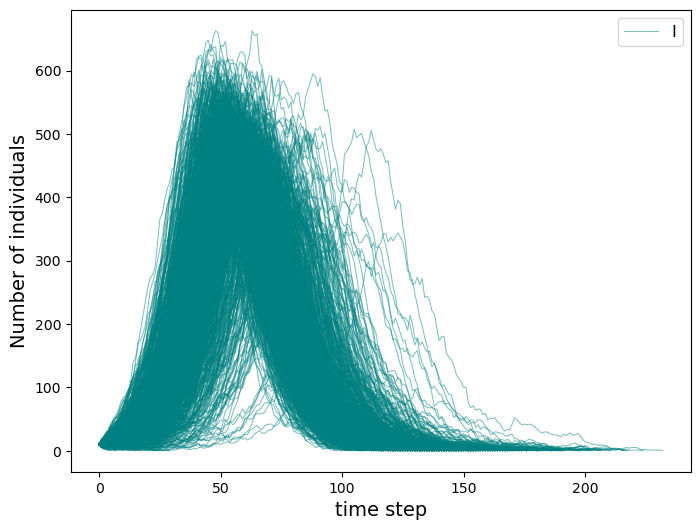

In [100]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.35,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [12]:
.25*1.25

0.3125

In [104]:
# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=150:
        Ifilt[n] = Iall[i][0:150]
        n+=1

In [105]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 151))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [9]:
Idf.trajectory_id.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [106]:
Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    if idx>50:
        d = Idf[Idf.trajectory_id==idx]
    else:
        d = Idf[Idf.trajectory_id==idx]
        d['time'] = d['time'] + 30

        maxtime = d.time.max()
        if maxtime<150:
            while maxtime<150:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1

        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
    d= d[d.time<=150]

    Ishift = pd.concat([Ishift,d])

(0.0, 150.0)

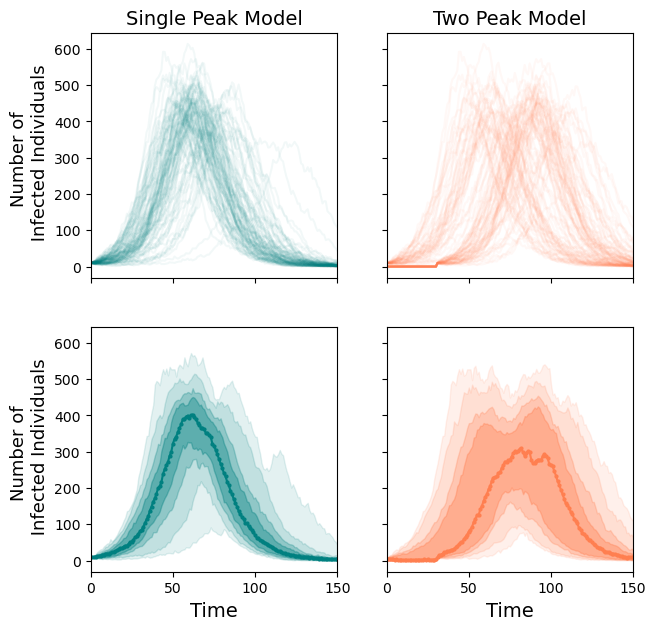

In [108]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
plt.title('Single Peak Model', fontsize=14)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
plt.title('Two Peak Model', fontsize=14)
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,150])

In [134]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.35,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=150:
            Ifilt[n] = Iall[i][0:150]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 151))

    for it in range(1, 1001):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])


    Idf['Model'] = 'SIR'
    
    dftot = Idf.copy()
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=150)]

    return dftot

In [185]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 1

ESdict = {}


truth = []
for i in range(numit):
    ES = []
    y=np.array([])
    while y.shape[0]<150:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.35,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:150]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=5000)
    dftot = dftot[dftot.Model=='SIR']
    
    errors = pd.DataFrame()
    for idx in dftot.trajectory_id.unique():
        df = dftot[dftot.trajectory_id==idx].sort_values(by='time')
        
        mse = np.square(np.subtract(y,list(df.I))).mean()
        
        errors = pd.concat([errors, pd.DataFrame({'trajectory_id':idx, 'mse':mse}, index=[0])])
        
    errors['rank'] = errors['mse'].rank()
    errors = errors[errors['rank']<=200]
    
    traj_list = []
    ranks = list(errors['rank'].unique())
    while len(ranks)>0 :
        traj_list.append(errors[errors['rank']==min(ranks)].trajectory_id.unique()[0])
        ranks.remove(min(ranks))
        
        X = np.array([np.array(dftot[dftot['trajectory_id'] == i].I) for i in traj_list]).astype(float) 

        # calculate scores
        ES.append(energyscore(X ,y))
        
ES_reg = ES.copy()

In [128]:
ESdict

{0: [241.76434807473166,
  185.3482313465086,
  160.62478490986308,
  144.93791138775077,
  144.70370579731883,
  146.26074701203785,
  149.99393974114778,
  148.58937673925553,
  147.44523066714444,
  150.06603768798894,
  152.5910193078187,
  148.70126700480458,
  147.01122288892842,
  146.15817813545996,
  146.15010214667646,
  147.69776435601358,
  148.88833570895966,
  151.06062828560945,
  151.69741754698038,
  153.68061107226856,
  155.98344094097848,
  156.33999512618837,
  159.039326165436,
  159.34850852262792,
  156.55494513132416,
  157.71316734741487,
  159.51574249820456,
  161.6462205989385,
  161.33673765558066,
  162.99702259809203,
  164.5651954661914,
  162.97415353441858,
  164.76236361227774,
  164.9595574042236,
  165.4090979155586,
  164.3052663128229,
  164.48125656090878,
  165.57065705235496,
  165.3502429443022,
  164.77865488456678,
  166.33877346916861,
  167.48447204439452,
  167.66157058938984,
  168.52454998246034,
  169.196986436955,
  169.2298945382883

Text(0, 0.5, 'Energy Score')

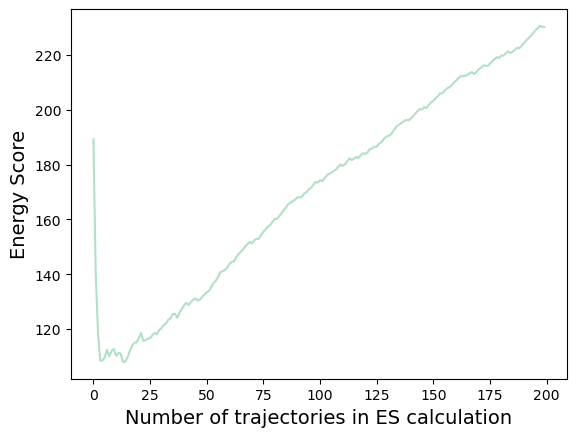

In [186]:
plt.plot(ES_reg,color='mediumseagreen', alpha=.4)
    
plt.xlabel('Number of trajectories in ES calculation', fontsize=14)
plt.ylabel('Energy Score', fontsize=14)

#plt.xscale('log')
#plt.xlim([-1, 50])

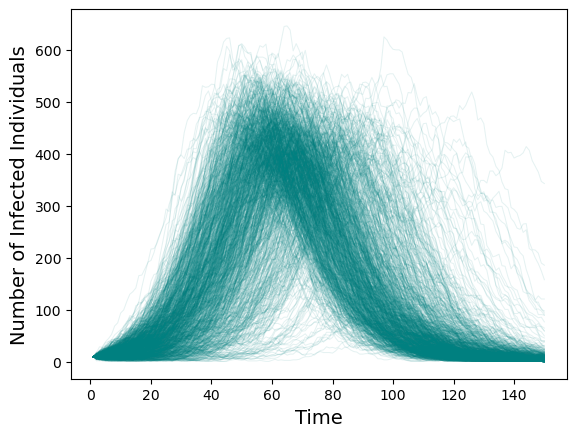

In [187]:
for n in dftot.trajectory_id.unique():
    df = dftot[dftot.trajectory_id==n]
    plt.plot(df.time,df.I, 'teal',linewidth=.75,  alpha=.1)
    
#plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Infected Individuals', fontsize=14)


plt.show()

In [208]:
ESdict_full = {}
errors = pd.DataFrame()
ES = []
for idx in dftot.trajectory_id.unique():
    df = dftot[(dftot.trajectory_id==idx) & (dftot.time<=20)].sort_values(by='time')

    mse = np.square(np.subtract(y[0:20],list(df.I))).mean()

    errors = pd.concat([errors, pd.DataFrame({'trajectory_id':idx, 'mse':mse}, index=[0])])

errors['rank'] = errors['mse'].rank()
errors = errors.sort_values(by='rank').reset_index().drop(columns=['index']).reset_index()
errors = errors[errors['index']<200]

traj_list = []
ranks = []
ranks = list(errors['index'].unique())
while len(ranks)>0 :
    traj_list.append(errors[errors['index']==min(ranks)].trajectory_id.unique()[0])
    ranks.remove(min(ranks))

    X = np.array([np.array(dftot[dftot['trajectory_id'] == i].I) for i in traj_list]).astype(float) 

    # calculate scores
    ES.append(energyscore(X ,y))
    
ES_full = ES.copy()

In [207]:
len(ES_reg)

200

In [209]:
ESdict_early = {}
errors = pd.DataFrame()
ES = []
for idx in dftot.trajectory_id.unique():
    df = dftot[(dftot.trajectory_id==idx) & (dftot.time<=20)].sort_values(by='time')

    mse = np.square(np.subtract(y[0:20],list(df.I))).mean()

    errors = pd.concat([errors, pd.DataFrame({'trajectory_id':idx, 'mse':mse}, index=[0])])

errors['rank'] = errors['mse'].rank()
errors = errors.sort_values(by='rank').reset_index().drop(columns=['index']).reset_index()
errors = errors[errors['index']<200]


traj_list = []
ranks = []
ranks = list(errors['index'].unique())
while len(ranks)>0 :
    dfuse = dftot[dftot.time<=20]
    traj_list.append(errors[errors['index']==min(ranks)].trajectory_id.unique()[0])
    ranks.remove(min(ranks))

    X = np.array([np.array(dfuse[dfuse['trajectory_id'] == i].I) for i in traj_list]).astype(float) 

    # calculate scores
    ES.append(energyscore(X ,y[0:20]))
    
ES_early = ES.copy()

Text(0, 0.5, 'Energy Score')

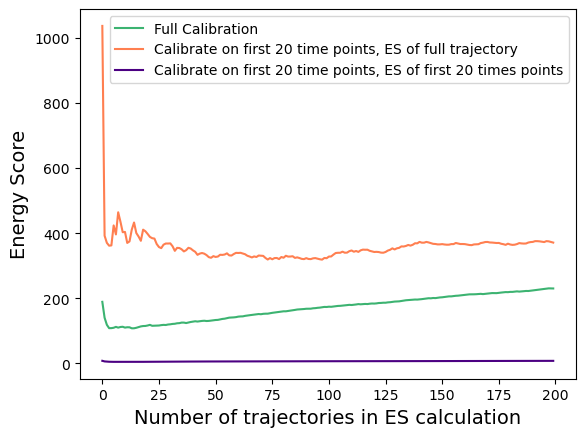

In [212]:
plt.plot(ES_reg,color='mediumseagreen', alpha=1,label='Full Calibration')
plt.plot(ES_full,color='coral', alpha=1, label = 'Calibrate on first 20 time points, ES of full trajectory')
plt.plot(ES_early,color='indigo', alpha=1,label='Calibrate on first 20 time points, ES of first 20 times points')

plt.legend()
plt.xlabel('Number of trajectories in ES calculation', fontsize=14)
plt.ylabel('Energy Score', fontsize=14)

#plt.xscale('log')
#plt.xlim([-1, 50])

Text(0, 0.5, 'Energy Score')

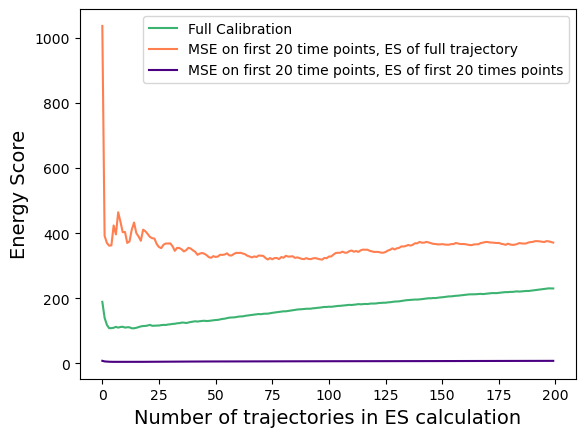

In [218]:
plt.plot(ES_reg,color='mediumseagreen', alpha=1,label='Full Calibration')
plt.plot(ES_full,color='coral', alpha=1, label = 'MSE on first 20 time points, ES of full trajectory')
plt.plot(ES_early,color='indigo', alpha=1,label='MSE on first 20 time points, ES of first 20 times points')

plt.legend()
plt.xlabel('Number of trajectories in ES calculation', fontsize=14)
plt.ylabel('Energy Score', fontsize=14)

#plt.xscale('log')
#plt.xlim([-1, 50])